In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as animation
import seaborn as sns

sns.set(font_scale=1.6, palette='RdBu')

# Методы оптимизации

Методы оптимизации широко используются в анализе данных и машинном обучении. Например, они применяются при обучении линейной регрессии с **lasso** или **elastic net** регуляризацией. Кроме того, на оптимизации функции потерь основано обучение любых нейронных сетей. Поэтому каждый, кто планирует заниматься анализом данных, должен знать основные методы оптимизации.

**Базовые элементы оптимизации.**

* Переменные &mdash; параметры, по которым требуется оптимизировать функцию.

* Ограничения &mdash; границы, в которых могут варьироваться переменные.

* Функция потерь &mdash; функция, которую минимизирует метод.

Постановка задачи оптимизации &mdash; определение функции потерь и переменных, по которым будет минимизироваться функция потерь и ограничений на эти переменные.

## Основные методы оптимизации.

Пусть задача оптимизации имеет вид $f(\theta) \to \min_\theta$, и $\nabla_{\theta} f(\theta)$ &mdash; градиент функции $f(\theta)$.

Все методы, рассматриваемые здесь, являются итеративными. Они последовательно приближают текущее значение параметра $\theta$ к оптимальному $\theta^*$.

О некоторых других продвинутых методах вы узнаете в разделе курса, посвященном нейросетям.

### Градиентный спуск (GD &mdash; Gradient Descent)

$$\theta_{t+1} = \theta_t - \eta \nabla_{\theta} f(\theta_t).$$

Здесь изменение параметра $\theta$ происходит по направлению антиградиента. Метод градиентного спуска основан на том факте, что антиградиент &mdash; направление наибольшего локального убывания функции. 

Поскольку, это свойство антиградиента локально, на каждом шаге антиградиент вычитается с заданным коэффициентом $\eta$, который часто называют коэффициентом скорости обучения или learning rate. Этот коэффициент, как правило, берут меньшим $1$, так как мы не хотим слишком сильно доверять каждому отдельному шагу. Подбор $\eta$ осуществляется пользователем.

Требуется также понять в какой момент следует остановить оптимизацию. Перечислим популярные критерии останова:
1. Лимит на число итераций. Останавливаемся, когда достигаем запланированного числа шагов оптимизации.
2. Early stopping. Останавливаемя когда не происходит уменьшения $f(\theta)$ в течение какого-то зафиксированного числа шагов.
3. Ограничение на норму невязки. Останавливаемя, когда норма невязки: $\Vert f(\theta_{t+1}) - f(\theta_t) \Vert$ становится ниже порога.

### Стохастический градиентный спуск (SGD &mdash; Stochastic Gradient Descent)

Пусть $f(\theta) = \frac{1}{n}\sum\limits_{i=1}^n f_i(\theta)$. В таком случае шаг градиентного спуска:

$$
\theta_{t+1} = \theta_t - 
    \eta \nabla_{\theta} \left( \frac{1}{n} \sum\limits_{i=1}^n f_i(\theta_t) \right).
$$

Определим шаг стохастического градиентного спуска:

$$
\theta_{t+1} = \theta_t - 
    \eta \nabla_{\theta} \left( \frac{1}{m} \sum\limits_{j=1}^m f_{i_j}(\theta_t) \right),
$$

где $i_1, \dots, i_m \sim U\{1, \dots, n\}$.

Таким образом, вместо того, чтобы вычислять градиент по всем $n$ функциям $f_i$, мы вычисляем его только по $m$ из них. Это может быть полезно, если все $f_i$ примерно равноправны, $n$ велико, а вычисление градиента по каждому $f_i$ является достаточно тяжелым. Тогда, взяв разумное $m$ нам удастся достаточно точно найти направление антиградиента и не потратить слишком много ресурсов.

*Замечание.*

Иногда SGD называют только случай, когда $m=1$, а при $1 < m < n$ это Mini-batch GD. 

## Эксперименты.

Нет универсального метода оптимизации, который всегда работает лучше, чем остальные. Поэтому для выбора наилучшего метода оптимизации и оптимальных гиперпараметров для него проводят ряд экспериментов. 

Интересующиеся могут почитать про "No free lunch theorem".

Ниже приведена визуализация нескольких экспериментов и сравнение скорости сходимости различных методов оптимизации, запущенных из одной точки.

Реализуем методы оптимизации.

In [4]:
def gradient_descent(theta0, func_grad, eta, iter_count=15_0):
    """Градиентный спуск.
    
    :param theta0: начальное приближение theta,
    :param func_grad: функция, задающая градиент оптимизируемой функции,
    :param eta: скорость обучения,
    :param iter_count: количество итераций метода.
    
    :returns: траектория
    """
    
    theta = theta0
    history = [theta0]
    
    for iter_id in range(iter_count):
        theta = theta - eta * func_grad(theta)
        history.append(theta)
    return history



Реализуем функции, которые будем оптимизировать.

In [5]:
def square_sum(x):
    return x[0]**5 + 5 * x[1]**2 + 5 * x

def square_sum_grad(x):
    return np.array([10, 2]) * x

def square_sum_hessian(x):
    return np.diag([10, 2])

Создадим директорию, в которой будем хранить визуализацию экспериментов.

In [6]:
!rm -rf saved_gifs
!mkdir saved_gifs

In [7]:
def make_experiment(func, trajectory, graph_title):
    """Функция, которая для заданной функции рисует её линии уровня, а также 
    траекторию сходимости метода оптимизации.
    
    :param func: оптимизируемая функция,
    :param trajectory: траектория метода оптимизации,
    :param graph_name: заголовок графика.
    """
    
    # задаем полотно
    fig, ax = plt.subplots(figsize=(10, 8))
    xdata, ydata = [], []
    ln, = plt.plot([], [])
    
    # определяем сетку для вычислений
    mesh = np.linspace(-15.0, 15.0, 300)
    X, Y = np.meshgrid(mesh, mesh)
    
    # проводим вычисления
    Z = func(np.stack((X, Y)))
    
    def init():
        """Функция, инициализирующая полотно."""
        # изображаем линии уровней
        ax.contour(X, Y, np.log(Z), 
                   np.log([2, 10, 30, 80, 130, 200, 300, 500, 900]), 
                   cmap='winter')
        ax.set_title(graph_title)
        return ln,

    def update(frame):
        """Функция, обновляющая кадр."""
        # добавляем новый шаг в траектории
        xdata.append(trajectory[frame][0])
        ydata.append(trajectory[frame][1])
        ln.set_data(xdata, ydata)
        return ln,
    
    ani = animation.FuncAnimation(
        fig, update, frames=range(len(trajectory)),
        init_func=init, repeat=True
    )
    ani.save(f'saved_gifs/{graph_title}.gif', 
             writer='imagemagick', fps=5)

In [8]:
import matplotlib
matplotlib.__version__

'3.5.3'

MovieWriter imagemagick unavailable; using Pillow instead.


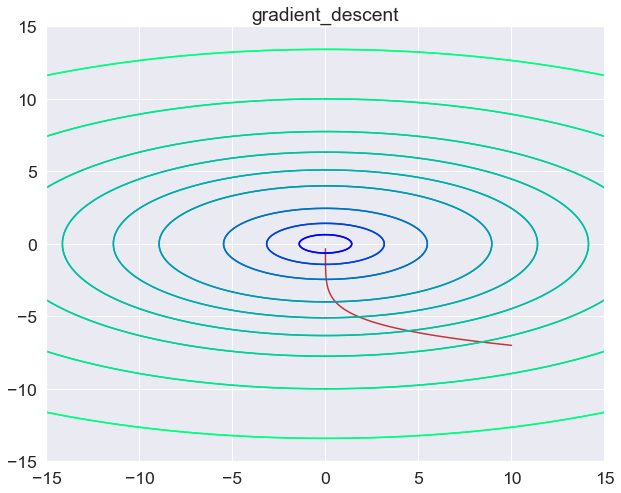

In [9]:
gd_trajectory = gradient_descent(
    np.array((10, -7)), square_sum_grad, 0.01
)
make_experiment(square_sum, gd_trajectory, 'gradient_descent')